# Wavelet estimator on Shevlin, Smith, Hausfeld, Krajbich dataset

In [1]:
#VERSION Julia 1.7.1

using CSV
using DataFrames
using LinearAlgebra
using Plots
using Statistics
using GLM

### Functions

In [2]:
# Preprocessing functions

function preprocess(data::DataFrame)
    filter!(x -> (x["colorBlind"] ==0), data)
    select!(data, [:LeftRight, :ValL, :ValR, :ValDif, :RT])
end

function filterPair(a::Int64,b::Int64,df::DataFrame)
    subdf = filter(x -> Set(x[["ValL","ValR"]]) == Set([a,b]),df)
    
    df_l = subdf[(subdf[:,"ValL"].==a),:]
    left = sum(df_l[:,"LeftRight"] .== 1)

    df_r = subdf[(subdf[:,"ValR"].==a),:]
    right = sum(df_r[:,"LeftRight"] .== 2)
    
    P = (left + right) / size(subdf)[1]
    DT = mean(subdf[:,"RT"])
    return P, DT
end


function getObservables(df, alts)
    @assert Set(df[:,"ValL"]) == Set(df[:,"ValR"])
    n = length(Set(df[:,"ValL"]))
    P = zeros(n,n)
    DT = Inf .* ones(n,n)
    for i in 1:size(df)[1]
        a = df[i,"ValL"]
        b = df[i,"ValR"]
        pos_a = findall(x -> x==a, alts)[1]
        pos_b = findall(x -> x==b, alts)[1]
        if DT[pos_a, pos_b] == Inf
            p, dt = filterPair(a, b, df)
            P[pos_a, pos_b] = p
            P[pos_b, pos_a] = 1 - p
            DT[pos_a, pos_b] = dt
            DT[pos_b, pos_a] = dt
        end
    end
    DT[diagind(DT)] .= 0.0
    P[diagind(P)] .= 0.5
    return P, DT
end

getObservables (generic function with 1 method)

In [3]:
function getComp(a::Int64, obs::Matrix{Float64}) #ALWAYS USE l (tilde) AS OBSERVABLE !!!
    return collect(1:size(obs)[1])[abs.(obs[a,:]) .!= Inf]  
end


function get_l(P::Matrix{Float64})
    l = log.(P ./ (1 .- P))
    return l
end

#l
function l_tilde(a::Int64, b::Int64, l::Matrix{Float64}, obs::Matrix{Float64})
    C_a = getComp(a, obs)
    C_b = getComp(b, obs)
    C = intersect(Set(C_a), Set(C_b))
    l̃ = 0
    n = length(C)
    n == 0 && return (false, -Inf) #a and b are not connected in the transitive comparison graph
    for c in C
        l̃ += (l[a,c] + l[c,b])
    end
    return (true, l̃/n)
end


function l_tilde(l::Matrix{Float64})
    n = size(l)[1]
    L̃ = -Inf .* ones(n,n)
    for a in 1:n
        @assert abs(l_tilde(a,a,l,l)[2]) < 1e-7
        L̃[a,a] = 0.0
        for b in (a+1):n
            conn, l̃ = l_tilde(a,b,l,l)
            if !conn
                L̃[a,b] = L̃[b,a] = -Inf
            else
                L̃[a,b] = l̃
                L̃[b,a] = -l̃
            end
        end
    end
    conn = (L̃ .> -Inf)  #if l̃[a,b] is -Inf, it means that a and b are not neighbors
    return L̃, conn
end


# DT
function DT_tilde(a::Int64, b::Int64, l::Matrix{Float64}, DT::Matrix{Float64})
    A_l = (l .> -Inf)    #i.e. conn (in the l-step, not in the DT-step)
    A_dt = (DT .< Inf)
    @assert (A_l .& A_dt) == A_dt    #i.e. A_dt <= A_l
    n = size(A_l)[1]
    !A_l[a,b] && return Inf
    a == b && return 0.0  #impose diagonal, think more about it later
    
    R = abs(l[a,b]) * (exp(abs(l[a,b])) + 1) / (exp(abs(l[a,b])) - 1)
    res = 0.0
    for c in 1:n
        for d in (c+1):n
            if A_dt[c,d]
                k = abs(l[c,d])
                r = k * (exp(k) + 1) / (exp(k) - 1)
                res += DT[c,d] * r
            end
        end
    end
    return 2*res / (R * (sum(A_dt) - n))
end


function DT_tilde(l::Matrix{Float64}, DT::Matrix{Float64})
    n = size(DT)[1]
    DT_t = Inf .* ones(n,n)
    for a in 1:n
        for b in a:n
            DT_t[a,b] = DT_tilde(a,b,l,DT)
            DT_t[b,a] = DT_t[a,b]
        end
    end
    return DT_t
end

DT_tilde (generic function with 2 methods)

In [4]:
#Wavelet

function wavelet(l::Matrix{Float64}, DT::Matrix{Float64}, new::Bool = true)
    @assert size(l)[1] == size(l)[2] == size(DT)[1] == size(DT)[2]
    n = size(l)[1]
    conn = (l .> -Inf)
    @assert conn == (DT .< Inf)
    
    if new
        k = abs(l[1,2])
        λ = DT[1,2] * k * (exp(k) + 1) / (exp(k) - 1)
    else
        λ = 0
        edges = (sum(conn) - n) / 2
        for a in 1:n
            for b in (a+1):n
                if conn[a,b]
                    k = abs(l[a,b])
                    λ += DT[a,b] * k * (exp(k) + 1) / (exp(k) - 1)
                end
            end
        end
        λ /= edges
    end
    
    return (sqrt(λ), l/sqrt(λ))
end

wavelet (generic function with 2 methods)

In [5]:
#DDM
DT_DDM(λ::Float64, udiff::Matrix{Float64}) = λ .* tanh.(λ .* udiff ./ 2) ./ udiff
DT_DDM(λ::Float64, udiff::Vector{Float64}) = λ .* tanh.(λ .* udiff ./ 2) ./ udiff
P_DDM(λ::Float64, udiff::Matrix{Float64}) = 1 ./ (1 .+ exp.(-λ.*udiff))
P_DDM(λ::Float64, udiff::Vector{Float64}) = 1 ./ (1 .+ exp.(-λ.*udiff))

P_DDM (generic function with 2 methods)

In [6]:
#visualization

function plot_obs(obs::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64})
    n = size(obs)[1]
    v = lam .* udiff
    idx = (obs .!= 0.0)
    y = obs[idx]
    x = v[idx]
    scatter(x,y)
end

function plot_obs(obs::Matrix{Float64}, v::Matrix{Float64})
    n = size(obs)[1]
    idx = (obs .!= 0.0)
    y = obs[idx]
    x = v[idx]
    scatter(x,y)
end

function plot_P(P::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, save::Bool=false, filename="P_plot_shevlin")
    n = size(P)[1]
    v = udiff
    idx = (P .!= 0.0) .& (P .!= 0.5) .& (v .> 0)
    x = v[idx]
    y = P[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    P_th = P_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed choice freq.", title="Wavelet estimator and empirical data (P)", legend=:topleft, dpi=500)
    plot!(grid, P_th, label = "elicited DDM")
    xlabel!("Δu (elicited)")
    ylabel!("P(a,b)")
  
    save && savefig(fig, filename)
    display(fig)
end

function plot_DT(DT::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, save::Bool=false, filename="DT_plot_shevlin")
    n = size(DT)[1]
    v = udiff
    idx = (DT .< Inf) .& (DT .!= 0) .& (v .> 0)
    x = v[idx]
    y = DT[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    DT_th = DT_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed mean DT", title="Wavelet estimator and empirical data (DT)", dpi=500)
    plot!(grid, DT_th, label = "elicited DDM") 
    xlabel!("Δu (elicited)")
    ylabel!("DT(a,b)")
    save && savefig(fig, filename)
    display(fig)
end

plot_DT (generic function with 3 methods)

### Analysis

In [7]:
df = CSV.read("Datasets/boxData_Final_simple.csv", DataFrame)

,SubjectNumber,Trial,Third,Instr,LeftRight,ValL,ValR,ValDif,colorBlind
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,1,3,1,2,61,66,-5,0
2,1,2,3,1,1,63,60,3,0
3,1,3,3,1,1,64,61,3,0
4,1,4,3,1,2,65,66,-1,0
5,1,5,3,1,1,64,61,3,0
6,1,6,3,1,1,67,65,2,0
7,1,7,3,1,2,60,65,-5,0
8,1,8,3,1,2,61,64,-3,0
9,1,9,3,1,1,65,64,1,0


In [8]:
preprocess(df)

,LeftRight,ValL,ValR,ValDif,RT
,Int64,Int64,Int64,Int64,Float64
1,2,61,66,-5,888.3
2,1,63,60,3,1411.5
3,1,64,61,3,1663.0
4,2,65,66,-1,879.48
5,1,64,61,3,870.38
6,1,67,65,2,1750.3
7,2,60,65,-5,875.29
8,2,61,64,-3,779.67
9,1,65,64,1,1150.7


In [9]:
alts = sort([i for i in Set(df[:,"ValL"])]);

In [10]:
P, DT = getObservables(df, alts);

In [11]:
P

27×27 Matrix{Float64}:
 0.5       0.314961  0.253731  0.143382  …  0.0        0.0        0.0
 0.685039  0.5       0.4375    0.212121     0.0        0.0        0.0
 0.746269  0.5625    0.5       0.38806      0.0        0.0        0.0
 0.856618  0.787879  0.61194   0.5          0.0        0.0        0.0
 0.898551  0.842105  0.783784  0.601504     0.0        0.0        0.0
 0.889952  0.861314  0.832981  0.708543  …  0.0        0.0        0.0
 0.0       0.905797  0.911765  0.902985     0.0        0.0        0.0
 0.0       0.0       0.885714  0.921965     0.0        0.0        0.0
 0.0       0.0       0.0       0.885714     0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 ⋮                                       ⋱             ⋮          


In [12]:
DT

27×27 Matrix{Float64}:
    0.0   1987.55  2076.98  1759.27  …    Inf      Inf      Inf      Inf
 1987.55     0.0   2256.33  2046.76       Inf      Inf      Inf      Inf
 2076.98  2256.33     0.0   2102.07       Inf      Inf      Inf      Inf
 1759.27  2046.76  2102.07     0.0        Inf      Inf      Inf      Inf
 1605.95  1664.93  1868.34  2052.26       Inf      Inf      Inf      Inf
 1551.63  1531.99  1665.71  2011.15  …    Inf      Inf      Inf      Inf
   Inf    1447.46  1674.13  1853.28       Inf      Inf      Inf      Inf
   Inf      Inf    1607.98  1442.9        Inf      Inf      Inf      Inf
   Inf      Inf      Inf    1428.33       Inf      Inf      Inf      Inf
   Inf      Inf      Inf      Inf         Inf      Inf      Inf      Inf
   Inf      Inf      Inf      Inf    …    Inf      Inf      Inf      Inf
   Inf      Inf      Inf      Inf         Inf      Inf      Inf      Inf
   Inf      Inf      Inf      Inf         Inf      Inf      Inf      Inf
    ⋮                       

## Analysis: Wavelet

In [13]:
l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
sum(l_diff[.!isnan.(l_diff)])

5.5289106626332796e-14

In [14]:
DT_til = DT_tilde(l_til2, DT);

In [15]:
λ, udiff = wavelet(l_til2, DT_til)

(65.1610688124221, [0.0 -0.008757132413570299 … -Inf -Inf; 0.008757132413570299 0.0 … -Inf -Inf; … ; -Inf -Inf … 0.0 -0.016962731184167835; -Inf -Inf … 0.016962731184167835 0.0])

---

## Visualization

To understand how well the Wavelet estimator fits the data, we need to plot it. In particular, we need to plot P and DT as a function of $\lambda \Delta u$

A note on masking on Julia:

Whenever matrices arrays are flattened, the resulting vector is filled column-wise (first column, second column, ..., last column). 

If M = [**a b ... n**], then vec(M) = [**a**\*, **b**\*, ..., **n**\*]

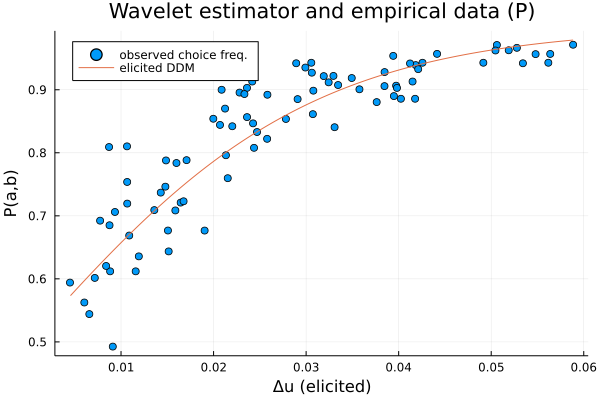

In [16]:
plot_P(P, λ, udiff)
savefig("P_plot_ShevlinWhole_21jan")

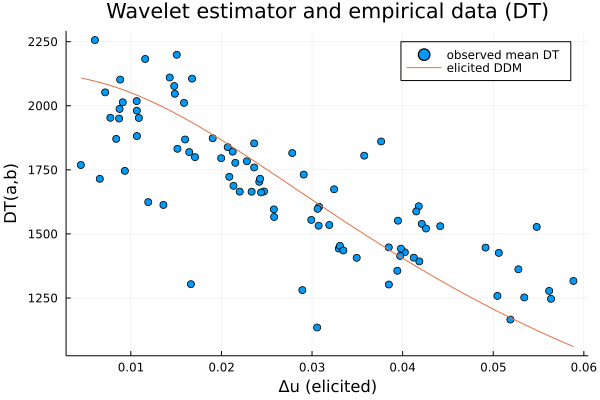

In [17]:
plot_DT(DT, λ, udiff)
savefig("DT_plot_ShevlinWhole_21jan")

## Value vs Utility

In [18]:
vdiff = zeros(Int64,(27,27))
for a in 1:27
    for b in a:27
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end
vdiff

27×27 Matrix{Int64}:
  0  -1  -2  -3  -4  -5  -6  -7  -8  …  -50  -51  -52  -53  -54  -55  -56
  1   0  -1  -2  -3  -4  -5  -6  -7     -49  -50  -51  -52  -53  -54  -55
  2   1   0  -1  -2  -3  -4  -5  -6     -48  -49  -50  -51  -52  -53  -54
  3   2   1   0  -1  -2  -3  -4  -5     -47  -48  -49  -50  -51  -52  -53
  4   3   2   1   0  -1  -2  -3  -4     -46  -47  -48  -49  -50  -51  -52
  5   4   3   2   1   0  -1  -2  -3  …  -45  -46  -47  -48  -49  -50  -51
  6   5   4   3   2   1   0  -1  -2     -44  -45  -46  -47  -48  -49  -50
  7   6   5   4   3   2   1   0  -1     -43  -44  -45  -46  -47  -48  -49
  8   7   6   5   4   3   2   1   0     -42  -43  -44  -45  -46  -47  -48
 24  23  22  21  20  19  18  17  16     -26  -27  -28  -29  -30  -31  -32
 25  24  23  22  21  20  19  18  17  …  -25  -26  -27  -28  -29  -30  -31
 26  25  24  23  22  21  20  19  18     -24  -25  -26  -27  -28  -29  -30
 27  26  25  24  23  22  21  20  19     -23  -24  -25  -26  -27  -28  -29
  ⋮              

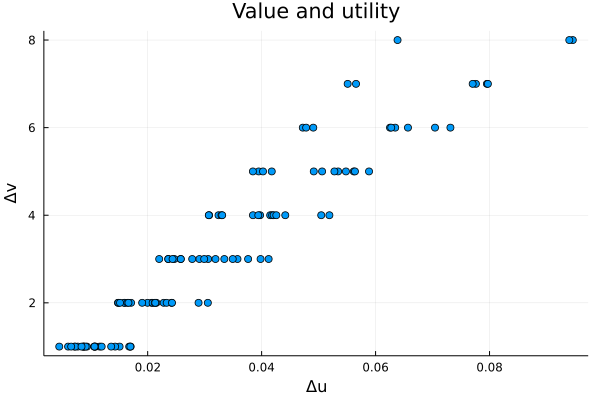

In [21]:
mask = udiff .> 0 
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=100)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")
display(fig)

In [22]:
data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

v ~ 1 + u

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   0.327642    0.113563   2.89    0.0047   0.102492   0.552793
u            89.5621      2.8721    31.18    <1e-54  83.8679    95.2563
─────────────────────────────────────────────────────────────────────────

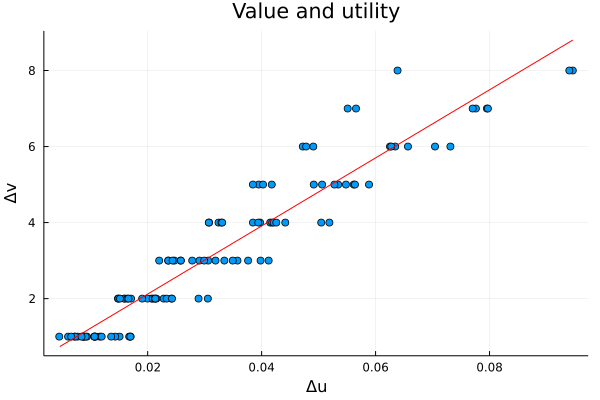

In [23]:
b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_21jan")
display(fig)

---

# Additional Analysis - January

In [24]:
function subgroup(third::Int64, instr::Int64, df)
    return df[(df[!,"Third"] .== third) .& (df[!,"Instr"] .== instr), :]
end

subgroup (generic function with 1 method)

In [25]:
df = CSV.read("Datasets/boxData_Final_simple.csv", DataFrame)

,SubjectNumber,Trial,Third,Instr,LeftRight,ValL,ValR,ValDif,colorBlind
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,1,3,1,2,61,66,-5,0
2,1,2,3,1,1,63,60,3,0
3,1,3,3,1,1,64,61,3,0
4,1,4,3,1,2,65,66,-1,0
5,1,5,3,1,1,64,61,3,0
6,1,6,3,1,1,67,65,2,0
7,1,7,3,1,2,60,65,-5,0
8,1,8,3,1,2,61,64,-3,0
9,1,9,3,1,1,65,64,1,0


In [26]:
third = 1
instr = 0

df1 = subgroup(third,instr,df)
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(65.52051207691956, [0.0 -0.00864594055252764 … -0.06345171166940054 -0.05473722246686573; 0.00864594055252764 0.0 … -0.05480577111687292 -0.04609128191433809; … ; 0.06345171166940054 0.05480577111687292 … 0.0 0.008714489202534812; 0.05473722246686573 0.04609128191433809 … -0.008714489202534812 0.0])

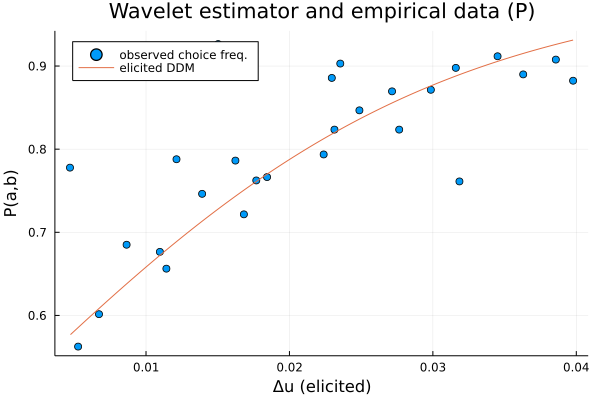

In [27]:
plot_P(P, λ, udiff, true, "P_plot_shevlin_10_21jan")

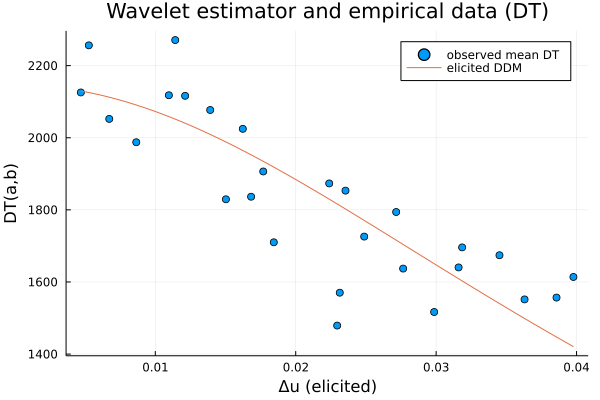

In [28]:
plot_DT(DT, λ, udiff, true, "DT_plot_shevlin_10_21jan")

In [29]:
k = length(alts)
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=500)
xlabel!("Δu")
ylabel!("Δv")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_10_21jan")

In [30]:
third = 1
instr = 1

df1 = subgroup(third,instr,df)
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(63.23025971702996, [0.0 -0.010058126087522967 … -0.062152067790352004 -0.07242743660058526; 0.010058126087522967 0.0 … -0.05209394170282904 -0.06236931051306227; … ; 0.062152067790352004 0.05209394170282904 … 0.0 -0.01027536881023325; 0.07242743660058526 0.06236931051306227 … 0.01027536881023325 0.0])

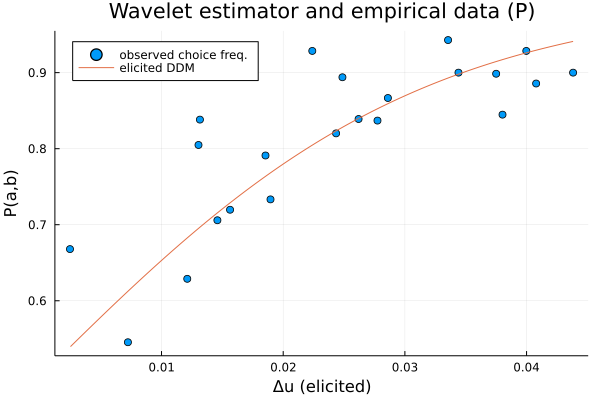

In [31]:
plot_P(P, λ, udiff, true, "P_plot_shevlin_11_21jan")

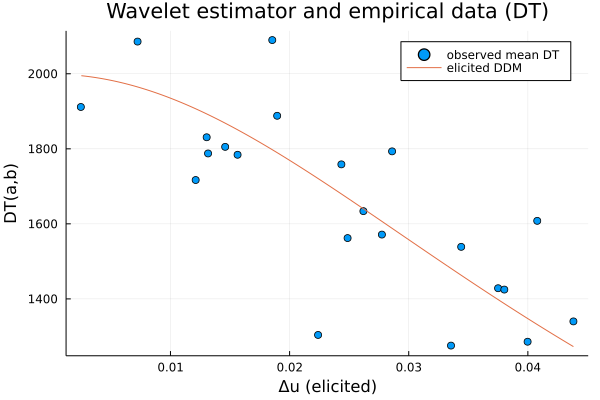

In [32]:
plot_DT(DT, λ, udiff, true, "DT_plot_shevlin_11_21jan")

In [33]:
k = length(alts)
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=500)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_11_21jan")

In [34]:
third = 2
instr = 0

df1 = subgroup(third,instr,df)
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(67.05820737356568, [0.0 -0.015072633351864548 … -0.07920387431646907 -0.08276047586339202; 0.015072633351864548 0.0 … -0.06413124096460451 -0.06768784251152749; … ; 0.07920387431646907 0.06413124096460451 … 0.0 -0.0035566015469229648; 0.08276047586339202 0.06768784251152749 … 0.0035566015469229648 0.0])

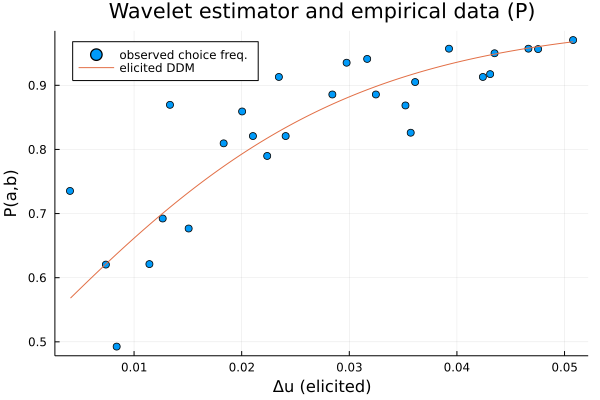

In [35]:
plot_P(P, λ, udiff, true, "P_plot_shevlin_20_21jan")

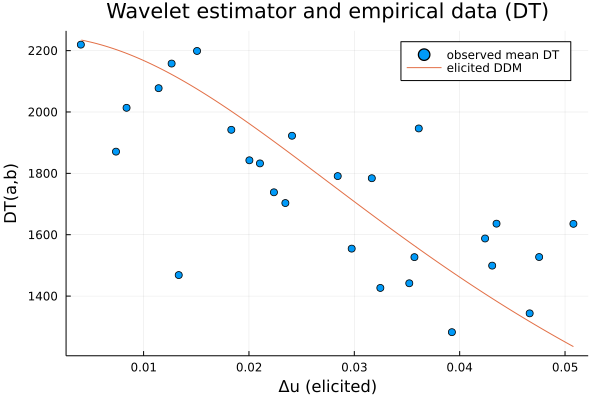

In [36]:
plot_DT(DT, λ, udiff, true, "DT_plot_shevlin_20_21jan")

In [37]:
k = length(alts)
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=500)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_20_21jan")

In [38]:
third = 2
instr = 1

df1 = subgroup(third,instr,df)
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(66.32008524495268, [0.0 -0.014894704988319319 … -0.08233124996069126 -0.10502846493912257; 0.014894704988319319 0.0 … -0.06743654497237192 -0.09013375995080326; … ; 0.08233124996069126 0.06743654497237192 … 0.0 -0.022697214978431333; 0.10502846493912257 0.09013375995080326 … 0.022697214978431333 0.0])

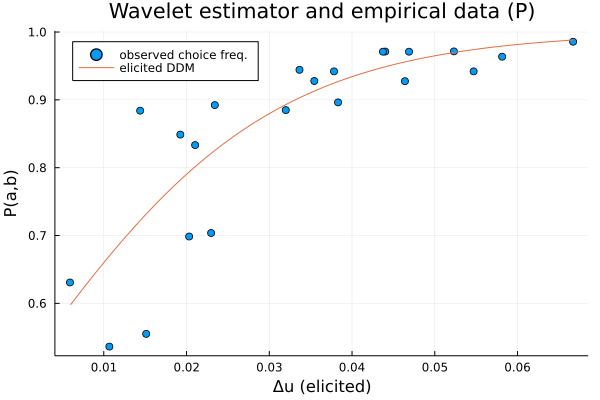

In [39]:
plot_P(P, λ, udiff, true, "P_plot_shevlin_21_21jan")

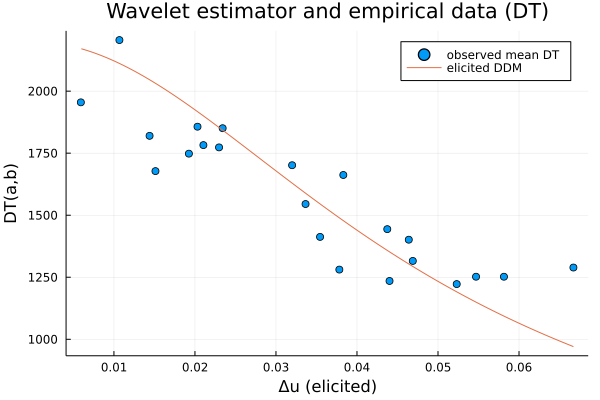

In [40]:
plot_DT(DT, λ, udiff, true, "DT_plot_shevlin_21_21jan")

In [41]:
k = length(alts)
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=100)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_21_21jan")

In [42]:
third = 3
instr = 0

df1 = subgroup(third,instr,df)
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(66.19921609973736, [0.0 -0.013835455798356081 … -0.08617670776452126 -0.08733516174675497; 0.013835455798356081 0.0 … -0.07234125196616516 -0.0734997059483989; … ; 0.08617670776452126 0.07234125196616516 … 0.0 -0.0011584539822337334; 0.08733516174675497 0.0734997059483989 … 0.0011584539822337334 0.0])

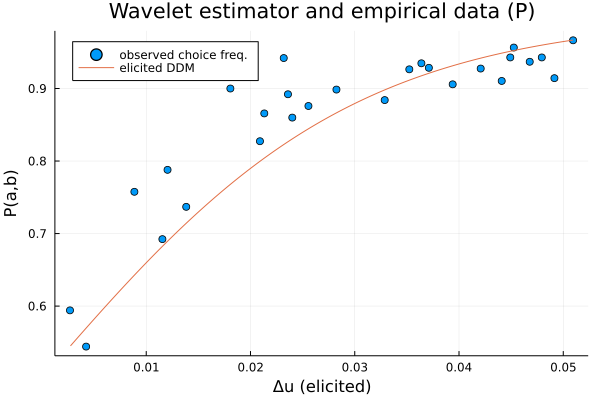

In [43]:
plot_P(P, λ, udiff, true, "P_plot_shevlin_30_21jan")

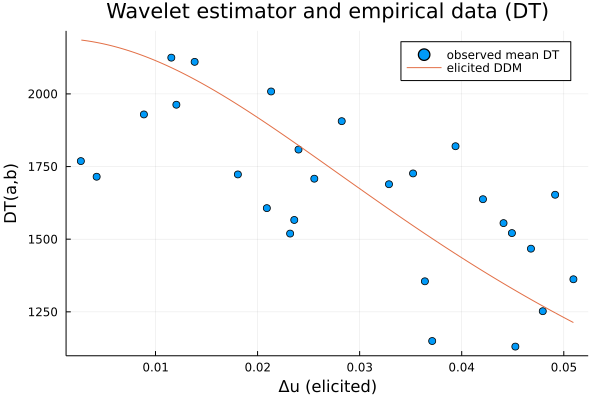

In [44]:
plot_DT(DT, λ, udiff, true, "DT_plot_shevlin_30_21jan")

In [45]:
k = length(alts)
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=100)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_30_21jan")

In [46]:
third = 3
instr = 1

df1 = subgroup(third,instr,df)
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(65.21294805733481, [0.0 -0.0053332555824664165 … -0.07391439945149318 -0.09225287721965757; 0.0053332555824664165 0.0 … -0.06858114386902676 -0.08691962163719115; … ; 0.07391439945149318 0.06858114386902676 … 0.0 -0.018338477768164396; 0.09225287721965757 0.08691962163719115 … 0.018338477768164396 0.0])

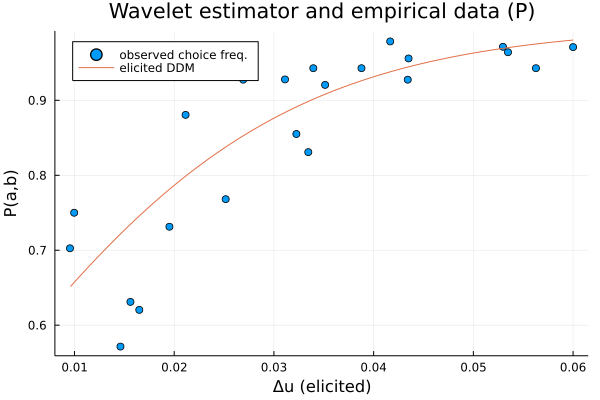

In [47]:
plot_P(P, λ, udiff, true, "P_plot_shevlin_31_21jan")

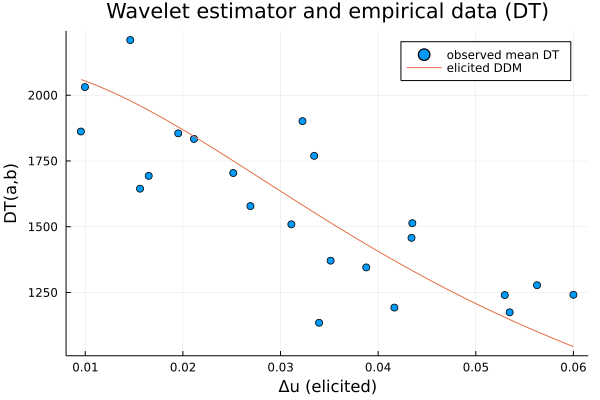

In [48]:
plot_DT(DT, λ, udiff, true, "DT_plot_shevlin_31_21jan")

In [49]:
k = length(alts)
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=100)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data)

b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")
savefig(fig, "v_vs_u_shevlin_31_21jan")

---

# Analysis removing instructed subjects

## (The coloring and new plotting functions do not change anything anymore)

In [66]:
df = CSV.read("Datasets/boxData_Final_simple.csv", DataFrame)
instr = 1   #change this to 0 or 1 to generate the plots for the corresponding sub-dataset
df1 = df[(df[!,"Instr"] .== instr), :]
preprocess(df1)
alts = sort([i for i in Set(df1[:,"ValL"])]);
P, DT = getObservables(df1, alts);

l = get_l(P)
l_til = l_tilde(l)[1]
l_til2 = l_tilde(l_til)[1]
l_til3 = l_tilde(l_til2)[1]

l_diff = abs.(l_til2 - l_til3)
@assert sum(l_diff[.!isnan.(l_diff)]) < 1e-10

DT_til = DT_tilde(l_til2, DT)
λ, udiff = wavelet(l_til2, DT_til)

(64.93367910185874, [0.0 -0.009794269069261879 … -Inf -Inf; 0.009794269069261879 0.0 … -Inf -Inf; … ; -Inf -Inf … 0.0 -0.01841734851139308; -Inf -Inf … 0.01841734851139308 0.0])

In [67]:
function get_mask(instr::Int64, P::Matrix{Float64}, lam::Float64, u::Matrix{Float64})
    if instr == 1
        mask = 0.45 .<= P .<= 0.55
        mask = mask .& .!(-1 .<= lam*u .<= 1)
    end
    if instr == 0
        mask = 0.34 .<= P .<= 0.66
        #mask = mask .& .!(-0.9 .<= lam*u .<= 0.9)
    end
    return mask
end

get_mask (generic function with 1 method)

In [68]:
function plot_P1(P::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, instr::Int64, save::Bool=false, filename="P_plot_shevlin")
    n = size(P)[1]
    v = lam .* udiff
    idx = (P .!= 0.0) .& (P .!= 0.5) .& (v .> 0)
    x = v[idx]
    y = P[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    P_th = P_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed choice freq.", title="Wavelet estimator and empirical data (P)", legend=:topleft, dpi=500)
    plot!(lam.*grid, P_th, label = "elicited DDM")
    xlabel!("λ(u(a)-u(b)) (elicited)")
    ylabel!("P(a,b)")
    
    mask = get_mask(instr, P, λ_new, udiff_new)
    scatter!(v[mask], P[mask], color=:green, label = "")
    save && savefig(fig, filename)
    display(fig)
end

function plot_P2(P::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, instr::Int64, save::Bool=false, filename="P_plot_shevlin")
    n = size(P)[1]
    v = udiff
    idx = (P .!= 0.0) .& (P .!= 0.5) .& (v .> 0)
    x = v[idx]
    y = P[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    P_th = P_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed choice freq.", title="Wavelet estimator and empirical data (P)", legend=:topleft, dpi=500)
    plot!(grid, P_th, label = "elicited DDM")
    xlabel!("Δu (elicited)")
    ylabel!("P(a,b)")
    
    save && savefig(fig, filename)
    display(fig)
end

plot_P2 (generic function with 3 methods)

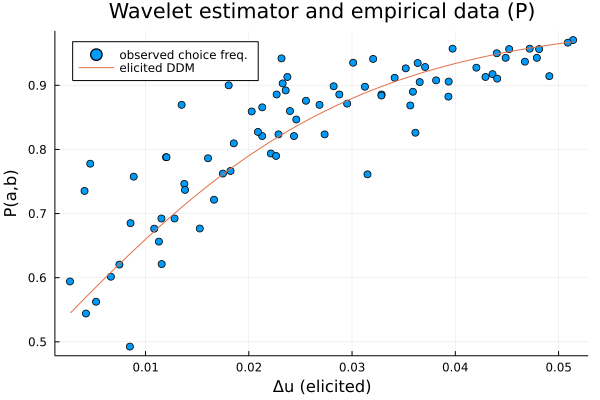

In [61]:
plot_P2(P, λ, udiff, instr)
savefig("P_plot_shevlin_instr0_jan21")

In [62]:
function plot_DT1(DT::Matrix{Float64}, lam::Float64, udiff::Matrix{Float64}, instr::Int64, save::Bool=false, filename="DT_plot_shevlin")
    n = size(DT)[1]
    v = udiff
    idx = (DT .< Inf) .& (DT .!= 0) .& (v .> 0)
    x = v[idx]
    y = DT[idx]
    
    u = udiff[idx]
    grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
    DT_th = DT_DDM(lam, grid)
    
    fig = scatter(x, y, label = "observed mean DT", title="Wavelet estimator and empirical data (DT)", dpi=500)
    plot!(grid, DT_th, label = "elicited DDM") 
    xlabel!("Δu (elicited)")
    ylabel!("DT(a,b)")
    
    save && savefig(fig, filename)
    display(fig)
end

plot_DT1 (generic function with 3 methods)

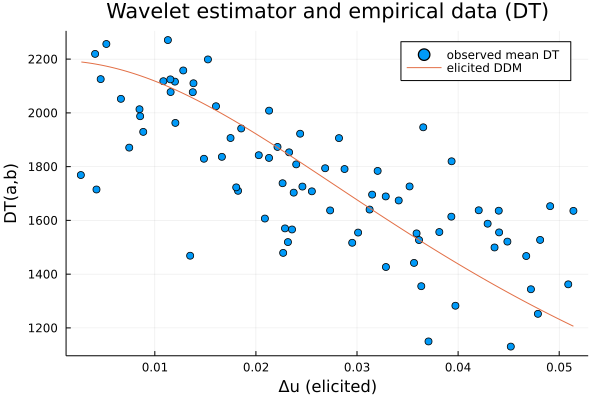

In [63]:
plot_DT1(DT, λ, udiff, instr)#, true, "DT_plot_shevlin_instr"*string(instr))
savefig("DT_plot_shevlin_instr0_jan21")

In [69]:
k = 27
vdiff = zeros(Int64,(k,k))
for a in 1:k
    for b in a:k
        vdiff[a,b] = alts[a] - alts[b]
        vdiff[b,a] = -vdiff[a,b]
    end
end

mask = udiff .> 0
u = udiff[mask]
v = vdiff[mask]
fig = scatter(u, v, title = "Value and utility", label="", dpi=500)
xlabel!("Δu")
ylabel!("Δv")
#savefig(fig, "v_vs_u_shevlin")

data = DataFrame([u,v], :auto);
Matrix(data)
rename!(data,:x1 => :u)
rename!(data,:x2 => :v)
ols = lm(@formula(v~u), data) 


b0, b1 = coef(ols)
grid = minimum(u) .+ (maximum(u) - minimum(u)) .* collect(1:1000) ./ 1000
line = b0 .+ b1*grid
plot!(grid, line, color = "red", label="")


savefig(fig, "v_vs_u_shevlin_instr1_21jan"*string(instr))